In [2]:
import pandas as pd
import numpy as np 
import geopandas as gpd
from shapely.geometry import MultiPolygon, Polygon
import json
from pyproj import Transformer
from PIL import Image

In [ ]:
import matplotlib.pyplot as plt

In [3]:
regions_path = "C:/Users/Dima/Desktop/MIP/stations/regions_selected_labeled.gpkg"

In [5]:
regions = gpd.read_file(regions_path)
regions.head() 

,id,RegionName,geometry
0,1,QLD Condamine-Balonne,"MULTIPOLYGON (((146.90174 -28.95673, 146.5 -28..."
1,2,NSW Barwon Darling,"MULTIPOLYGON (((144.18743 -29.03522, 148.2859 ..."
2,3,QLD Moonie,"MULTIPOLYGON (((148.60325 -28.94576, 148.77205..."
3,4,NSW Murray Above,"MULTIPOLYGON (((147.31699 -35.96701, 147.34906..."
4,5,NSW Lower Darling,"MULTIPOLYGON (((141.05399 -33.28225, 141.08446..."


In [6]:
regions["geometry"] = regions["geometry"].apply(lambda geom: geom.buffer(0) if not geom.is_valid else geom)

In [7]:
regions.geometry.crs

<Geographic 2D CRS: GEOGCS["GCS_GDA2020",DATUM["Geocentric_Datum_of_Au ...>
Name: GCS_GDA2020
Axis Info [ellipsoidal]:
- lon[east]: Longitude (Degree)
- lat[north]: Latitude (Degree)
Area of Use:
- undefined
Datum: Geocentric_Datum_of_Australia_2020
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [8]:
gdf_proj = regions.to_crs("EPSG:7856")
gdf_proj

,id,RegionName,geometry
0,1,QLD Condamine-Balonne,"MULTIPOLYGON (((-140405.545 6970530.865, -1431..."
1,2,NSW Barwon Darling,"MULTIPOLYGON (((-359853.554 6755855.004, 40547..."
2,3,QLD Moonie,"MULTIPOLYGON (((71308.265 6790053.067, 87434.9..."
3,4,NSW Murray Above,"MULTIPOLYGON (((-12671.543 6004749.737, -9927...."
4,5,NSW Lower Darling,"MULTIPOLYGON (((-615588.187 6253035.803, -6128..."
5,6,QLD Border Rivers,"MULTIPOLYGON (((110509.805 6793376.406, 109162..."
6,7,NSW Border Rivers,"MULTIPOLYGON (((124571.575 6802368.053, 132572..."
7,8,NSW Gwydir,"MULTIPOLYGON (((372889.686 6685494.956, 373502..."
8,9,NSW Namoi,"MULTIPOLYGON (((49520.477 6679281.937, 58231.7..."
9,10,NSW Macquarie-Castlereagh,"MULTIPOLYGON (((-109697.361 6406441.319, -1131..."


In [9]:
gdf_proj.total_bounds

array([-626592.70005512, 5929370.91298769,  454508.98534943,
       7219158.44531166])

In [10]:
x_min, y_min, x_max, y_max = gdf_proj.total_bounds

In [11]:
transformer = Transformer.from_crs("EPSG:7844", "EPSG:7856", always_xy = True)

In [12]:
W, H = 500, 596

In [ ]:
scale_x = W / (x_max - x_min)
scale_y = H / (y_max - y_min)

In [ ]:
def projected_to_pixel(x, y):
    px = (x - x_min) * scale_x
    py = H - ((y - y_min) * scale_y)
    return round(px), round(py)

In [15]:
def projected_to_pixel_coords(coords):
    return [projected_to_pixel(x, y) for x, y in coords]

In [16]:
def polygon_to_pixels(polygon):
    pixel_polygons = []

    if isinstance(polygon, Polygon):
        coords = list(polygon.exterior.coords)
        pixel_polygons.append(projected_to_pixel_coords(coords))

    elif isinstance(polygon, MultiPolygon):
        for poly in polygon.geoms:
            coords = list(poly.exterior.coords)
            pixel_polygons.append(projected_to_pixel_coords(coords))

    return pixel_polygons

In [17]:
gdf_proj["pixel_polygons"] = gdf_proj.geometry.apply(polygon_to_pixels)
gdf_proj["pixel_polygons"]

0     [[(225, 115), (224, 107), (226, 107), (226, 10...
1     [[(123, 214), (309, 201), (343, 198), (349, 20...
2     [[(323, 198), (330, 194), (328, 188), (328, 18...
3     [[(284, 561), (285, 560), (288, 560), (290, 55...
4     [[(5, 446), (6, 446), (0, 392), (4, 386), (7, ...
5     [[(341, 197), (340, 195), (340, 193), (341, 19...
6     [[(347, 193), (351, 191), (352, 190), (353, 18...
7     [[(462, 247), (463, 258), (464, 260), (461, 26...
8     [[(313, 249), (317, 245), (319, 245), (321, 24...
9     [[(239, 376), (237, 371), (236, 368), (235, 36...
10    [[(131, 484), (134, 482), (138, 479), (141, 47...
11    [[(108, 508), (109, 506), (112, 507), (118, 50...
Name: pixel_polygons, dtype: object

In [18]:
regions_coords = gdf_proj[["RegionName", "pixel_polygons"]].copy()
regions_coords

,RegionName,pixel_polygons
0,QLD Condamine-Balonne,"[[(225, 115), (224, 107), (226, 107), (226, 10..."
1,NSW Barwon Darling,"[[(123, 214), (309, 201), (343, 198), (349, 20..."
2,QLD Moonie,"[[(323, 198), (330, 194), (328, 188), (328, 18..."
3,NSW Murray Above,"[[(284, 561), (285, 560), (288, 560), (290, 55..."
4,NSW Lower Darling,"[[(5, 446), (6, 446), (0, 392), (4, 386), (7, ..."
5,QLD Border Rivers,"[[(341, 197), (340, 195), (340, 193), (341, 19..."
6,NSW Border Rivers,"[[(347, 193), (351, 191), (352, 190), (353, 18..."
7,NSW Gwydir,"[[(462, 247), (463, 258), (464, 260), (461, 26..."
8,NSW Namoi,"[[(313, 249), (317, 245), (319, 245), (321, 24..."
9,NSW Macquarie-Castlereagh,"[[(239, 376), (237, 371), (236, 368), (235, 36..."


In [19]:
aspect_proj = (x_max - x_min) / (y_max - y_min)
aspect_img = W / H

In [20]:
aspect_img

0.8389261744966443

In [21]:
def norm_string(string):
    string = string.lower()
    string = string.replace("-", "_")
    return string.replace(" ", "_")

In [22]:
[norm_string(name) for name in regions_coords.RegionName]

['qld_condamine_balonne',
 'nsw_barwon_darling',
 'qld_moonie',
 'nsw_murray_above',
 'nsw_lower_darling',
 'qld_border_rivers',
 'nsw_border_rivers',
 'nsw_gwydir',
 'nsw_namoi',
 'nsw_macquarie_castlereagh',
 'nsw_lachlan',
 'nsw_murrumbidgee']

In [23]:
regions_coords["href"] = [norm_string(name) for name in regions_coords.RegionName]
regions_coords

,RegionName,pixel_polygons,href
0,QLD Condamine-Balonne,"[[(225, 115), (224, 107), (226, 107), (226, 10...",qld_condamine_balonne
1,NSW Barwon Darling,"[[(123, 214), (309, 201), (343, 198), (349, 20...",nsw_barwon_darling
2,QLD Moonie,"[[(323, 198), (330, 194), (328, 188), (328, 18...",qld_moonie
3,NSW Murray Above,"[[(284, 561), (285, 560), (288, 560), (290, 55...",nsw_murray_above
4,NSW Lower Darling,"[[(5, 446), (6, 446), (0, 392), (4, 386), (7, ...",nsw_lower_darling
5,QLD Border Rivers,"[[(341, 197), (340, 195), (340, 193), (341, 19...",qld_border_rivers
6,NSW Border Rivers,"[[(347, 193), (351, 191), (352, 190), (353, 18...",nsw_border_rivers
7,NSW Gwydir,"[[(462, 247), (463, 258), (464, 260), (461, 26...",nsw_gwydir
8,NSW Namoi,"[[(313, 249), (317, 245), (319, 245), (321, 24...",nsw_namoi
9,NSW Macquarie-Castlereagh,"[[(239, 376), (237, 371), (236, 368), (235, 36...",nsw_macquarie_castlereagh


In [24]:
def normalize_polygon_coords(pixel_polygons):
    all_points = [pt for poly in pixel_polygons for pt in poly]
    min_x = min(x for x, y in all_points)
    min_y = min(y for x, y in all_points)

    normalized = []
    for poly in pixel_polygons:
        shifted = [(x - min_x, y - min_y) for x, y in poly]
        normalized.append(shifted)

    return normalized

In [25]:
regions_coords["normalized_polygons"] = regions_coords["pixel_polygons"].apply(normalize_polygon_coords)

In [26]:
regions_coords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   RegionName           12 non-null     object
 1   pixel_polygons       12 non-null     object
 2   href                 12 non-null     object
 3   normalized_polygons  12 non-null     object
dtypes: object(4)
memory usage: 516.0+ bytes


In [27]:
regions_coords

,RegionName,pixel_polygons,href,normalized_polygons
0,QLD Condamine-Balonne,"[[(225, 115), (224, 107), (226, 107), (226, 10...",qld_condamine_balonne,"[[(15, 115), (14, 107), (16, 107), (16, 108), ..."
1,NSW Barwon Darling,"[[(123, 214), (309, 201), (343, 198), (349, 20...",nsw_barwon_darling,"[[(69, 16), (255, 3), (289, 0), (295, 3), (291..."
2,QLD Moonie,"[[(323, 198), (330, 194), (328, 188), (328, 18...",qld_moonie,"[[(0, 84), (7, 80), (5, 74), (5, 70), (4, 64),..."
3,NSW Murray Above,"[[(284, 561), (285, 560), (288, 560), (290, 55...",nsw_murray_above,"[[(0, 16), (1, 15), (4, 15), (6, 13), (10, 13)..."
4,NSW Lower Darling,"[[(5, 446), (6, 446), (0, 392), (4, 386), (7, ...",nsw_lower_darling,"[[(5, 107), (6, 107), (0, 53), (4, 47), (7, 44..."
5,QLD Border Rivers,"[[(341, 197), (340, 195), (340, 193), (341, 19...",qld_border_rivers,"[[(1, 72), (0, 70), (0, 68), (1, 67), (4, 65),..."
6,NSW Border Rivers,"[[(347, 193), (351, 191), (352, 190), (353, 18...",nsw_border_rivers,"[[(0, 17), (4, 15), (5, 14), (6, 12), (8, 11),..."
7,NSW Gwydir,"[[(462, 247), (463, 258), (464, 260), (461, 26...",nsw_gwydir,"[[(128, 60), (129, 71), (130, 73), (127, 77), ..."
8,NSW Namoi,"[[(313, 249), (317, 245), (319, 245), (321, 24...",nsw_namoi,"[[(5, 8), (9, 4), (11, 4), (13, 5), (14, 3), (..."
9,NSW Macquarie-Castlereagh,"[[(239, 376), (237, 371), (236, 368), (235, 36...",nsw_macquarie_castlereagh,"[[(9, 103), (7, 98), (6, 95), (5, 89), (6, 88)..."


In [ ]:
regions_coords

In [28]:
regions_coords.normalized_polygons

0     [[(15, 115), (14, 107), (16, 107), (16, 108), ...
1     [[(69, 16), (255, 3), (289, 0), (295, 3), (291...
2     [[(0, 84), (7, 80), (5, 74), (5, 70), (4, 64),...
3     [[(0, 16), (1, 15), (4, 15), (6, 13), (10, 13)...
4     [[(5, 107), (6, 107), (0, 53), (4, 47), (7, 44...
5     [[(1, 72), (0, 70), (0, 68), (1, 67), (4, 65),...
6     [[(0, 17), (4, 15), (5, 14), (6, 12), (8, 11),...
7     [[(128, 60), (129, 71), (130, 73), (127, 77), ...
8     [[(5, 8), (9, 4), (11, 4), (13, 5), (14, 3), (...
9     [[(9, 103), (7, 98), (6, 95), (5, 89), (6, 88)...
10    [[(0, 112), (3, 110), (7, 107), (10, 105), (10...
11    [[(0, 62), (1, 60), (4, 61), (10, 60), (11, 57...
Name: normalized_polygons, dtype: object

In [29]:
[pd.Series(x) for x in regions_coords.normalized_polygons]

[0    [(15, 115), (14, 107), (16, 107), (16, 108), (...
 1         [(154, 67), (153, 67), (155, 63), (154, 67)]
 dtype: object,
 0    [(69, 16), (255, 3), (289, 0), (295, 3), (291,...
 dtype: object,
 0    [(0, 84), (7, 80), (5, 74), (5, 70), (4, 64), ...
 dtype: object,
 0    [(0, 16), (1, 15), (4, 15), (6, 13), (10, 13),...
 dtype: object,
 0    [(5, 107), (6, 107), (0, 53), (4, 47), (7, 44)...
 dtype: object,
 0    [(1, 72), (0, 70), (0, 68), (1, 67), (4, 65), ...
 dtype: object,
 0    [(0, 17), (4, 15), (5, 14), (6, 12), (8, 11), ...
 dtype: object,
 0    [(128, 60), (129, 71), (130, 73), (127, 77), (...
 dtype: object,
 0    [(5, 8), (9, 4), (11, 4), (13, 5), (14, 3), (1...
 dtype: object,
 0    [(9, 103), (7, 98), (6, 95), (5, 89), (6, 88),...
 dtype: object,
 0    [(0, 112), (3, 110), (7, 107), (10, 105), (10,...
 dtype: object,
 0    [(0, 62), (1, 60), (4, 61), (10, 60), (11, 57)...
 dtype: object]

In [30]:
regions_coords["normalized_polygons"].loc[1]

[[(69, 16),
  (255, 3),
  (289, 0),
  (295, 3),
  (291, 8),
  (286, 11),
  (283, 14),
  (279, 20),
  (280, 21),
  (278, 26),
  (280, 30),
  (286, 34),
  (293, 36),
  (299, 38),
  (318, 39),
  (323, 38),
  (329, 38),
  (332, 41),
  (333, 49),
  (337, 52),
  (337, 54),
  (335, 57),
  (330, 56),
  (322, 57),
  (312, 56),
  (307, 51),
  (303, 49),
  (294, 46),
  (289, 45),
  (279, 43),
  (275, 42),
  (271, 44),
  (267, 46),
  (262, 47),
  (258, 50),
  (251, 54),
  (263, 63),
  (266, 68),
  (268, 70),
  (270, 77),
  (275, 83),
  (279, 86),
  (284, 87),
  (289, 90),
  (293, 99),
  (294, 111),
  (293, 113),
  (290, 109),
  (285, 102),
  (280, 101),
  (275, 99),
  (269, 98),
  (265, 102),
  (263, 108),
  (266, 113),
  (266, 118),
  (263, 118),
  (257, 113),
  (250, 106),
  (248, 101),
  (245, 96),
  (241, 91),
  (237, 84),
  (235, 78),
  (229, 74),
  (226, 79),
  (225, 88),
  (225, 95),
  (223, 100),
  (224, 108),
  (229, 114),
  (231, 117),
  (233, 122),
  (234, 126),
  (233, 132),
  (231, 12

In [31]:
regions_coords["normalized_polygons"].loc[0]

[[(15, 115),
  (14, 107),
  (16, 107),
  (16, 108),
  (16, 108),
  (16, 107),
  (16, 107),
  (20, 104),
  (24, 101),
  (27, 97),
  (25, 94),
  (26, 90),
  (28, 88),
  (34, 89),
  (35, 88),
  (39, 88),
  (40, 89),
  (45, 81),
  (53, 76),
  (55, 70),
  (58, 63),
  (61, 61),
  (61, 56),
  (60, 54),
  (52, 49),
  (52, 45),
  (56, 35),
  (60, 31),
  (61, 29),
  (62, 25),
  (71, 17),
  (72, 14),
  (74, 12),
  (72, 11),
  (72, 7),
  (81, 0),
  (84, 1),
  (87, 4),
  (90, 8),
  (93, 10),
  (96, 12),
  (97, 15),
  (100, 19),
  (99, 23),
  (101, 27),
  (99, 29),
  (98, 32),
  (97, 41),
  (96, 45),
  (97, 50),
  (95, 52),
  (97, 56),
  (98, 57),
  (101, 54),
  (113, 54),
  (117, 55),
  (119, 61),
  (124, 62),
  (129, 65),
  (132, 67),
  (134, 66),
  (137, 66),
  (154, 67),
  (154, 67),
  (159, 68),
  (161, 69),
  (163, 68),
  (166, 69),
  (171, 71),
  (173, 72),
  (177, 70),
  (181, 69),
  (188, 63),
  (187, 61),
  (188, 59),
  (187, 58),
  (189, 58),
  (192, 59),
  (195, 60),
  (198, 62),
  (203,

In [32]:
with open("app/files/regions.json") as f:
    regions = json.load(f)


In [60]:
def get_bounds(polygons):
    all_points = [pt for poly in polygons for pt in poly]
    min_x = min(x for x, _ in all_points)
    max_x = max(x for x, _ in all_points)
    min_y = min(y for _, y in all_points)
    max_y = max(y for _, y in all_points)
    return min_x, max_x, min_y, max_y

In [66]:
regions[0].keys()

dict_keys(['RegionName', 'pixel_polygons', 'href', 'normalized_polygons'])

In [69]:
for i in range(12):
    print(regions[i]["href"], " : ", pd.Series(regions[i]["normalized_polygons"]))

qld_condamine_balonne  :  0    [[15, 115], [14, 107], [16, 107], [16, 108], [...
1         [[154, 67], [153, 67], [155, 63], [154, 67]]
dtype: object
nsw_barwon_darling  :  0    [[69, 16], [255, 3], [289, 0], [295, 3], [291,...
dtype: object
qld_moonie  :  0    [[0, 84], [7, 80], [5, 74], [5, 70], [4, 64], ...
dtype: object
nsw_murray_above  :  0    [[0, 16], [1, 15], [4, 15], [6, 13], [10, 13],...
dtype: object
nsw_lower_darling  :  0    [[5, 107], [6, 107], [0, 53], [4, 47], [7, 44]...
dtype: object
qld_border_rivers  :  0    [[1, 72], [0, 70], [0, 68], [1, 67], [4, 65], ...
dtype: object
nsw_border_rivers  :  0    [[0, 17], [4, 15], [5, 14], [6, 12], [8, 11], ...
dtype: object
nsw_gwydir  :  0    [[128, 60], [129, 71], [130, 73], [127, 77], [...
dtype: object
nsw_namoi  :  0    [[5, 8], [9, 4], [11, 4], [13, 5], [14, 3], [1...
dtype: object
nsw_macquarie_castlereagh  :  0    [[9, 103], [7, 98], [6, 95], [5, 89], [6, 88],...
dtype: object
nsw_lachlan  :  0    [[0, 112], [3, 110], [7,

In [70]:
ref = regions[0]["href"]

In [55]:
region_slug_map = {region["href"]: region for region in regions}

In [ ]:
r = region_slug_map.get(ref)

In [57]:
def get_bounds(polygons):
    all_points = [pt for poly in polygons for pt in poly]
    min_x = min(x for x, _ in all_points)
    max_x = max(x for x, _ in all_points)
    min_y = min(y for _, y in all_points)
    max_y = max(y for _, y in all_points)
    return min_x, max_x, min_y, max_y

In [71]:
ref = regions[0]["href"]

In [72]:
min_x, max_x, min_y, max_y = get_bounds(region_slug_map.get(ref)["normalized_polygons"])
print("Min_x : ", min_x)
print("Max_x : ", max_x)
print("Min_y : ", min_y)
print("Max_y : ",max_y)

Min_x :  0
Max_x :  290
Min_y :  0
Max_y :  202


In [ ]:
json_data = regions_coords.to_dict(orient = "records")
with open('regions.json', 'w') as f:
    json.dump(json_data, f)

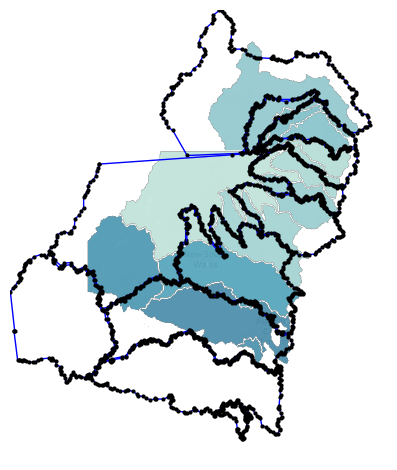

In [ ]:
img = plt.imread("map.png")
fig, ax = plt.subplots()

# Show image
ax.imshow(img)

# Loop through all regions
for _, row in regions_coords.iterrows():
    for poly in row["pixel_polygons"]:
        x, y = zip(*poly)
        ax.plot(x, y, "-", linewidth = 1, color = "blue")
        ax.plot(x, y, "o", markersize = 2, color = "black")

# Remove axes
ax.axis("off")

plt.tight_layout()
plt.show()